## Student ID: 190428550

### Machine Learning and Neural Networks - Template (1)
### Deep Learning on a Public Dataset

##### *This notebook will contain the third iteration of our project, where we will attempt to create a well performing model using the Keras Functional API. This is a continuation of the 2nd iteration. Any new findings will be reported in new sections.*


In [2]:
# pip install tensorflow
# pip install keras
# pip install pydot
# install graphviz

In [3]:
import pandas as pd
import numpy as np
import os

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as keras

In [4]:
tf.__version__

'2.9.0-dev20220304'

In [5]:
# read in data from csv, extract 100k samples
# processing data from the other columns

airplane_data = pd.read_csv("2005.csv")
airplane_data = airplane_data.sample(n=100000)

airplane_data['CRSDepTime'].isna().sum() # There are no NA's

airplane_data['CRSDepTime'] = airplane_data['CRSDepTime'].astype(str)
length_of_crsdeptime = airplane_data['CRSDepTime'].str.len()
airplane_data['HourOfDay'] = np.select([length_of_crsdeptime==4, length_of_crsdeptime==3, length_of_crsdeptime<3], [airplane_data['CRSDepTime'].str[0:2], airplane_data['CRSDepTime'].str[0:1], 0], np.nan)
airplane_data['HourOfDay'] = airplane_data['HourOfDay'].astype(int)

In [6]:
# adding a column to determine if flight was delayed based on the arrival delay time

airplane_data = airplane_data.copy()
airplane_data['Delayed'] = np.where(airplane_data['ArrDelay'] > 15, 1, 0) # Creating 'Delayed' column. Delayed = 1 if ArrDelay exceeds 15 minutes, 0 otherwise. 
airplane_data = airplane_data[['Month', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'HourOfDay', 'Delayed']] # Keeping only columns that will be used as features and target variable.

In [7]:
airplane_data.head()

,Month,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,HourOfDay,Delayed
1715795,3,6,DH,PVD,IAD,372,18,1
4874577,9,5,US,BDL,PHL,196,6,0
114681,1,3,WN,SJC,LAX,308,10,0
6840486,12,1,UA,SFO,PDX,550,6,0
4613939,8,3,HP,PHX,LAX,370,16,1


In [8]:
dataframe = airplane_data

### Split the dataset into training, validation and testing sets, 80:10:10 ratio

In [9]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [10]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

80000 training examples
10000 validation examples
10000 test examples


### Creating an input pipline using tf.data

In [11]:
# Convert training, validation and testing sets dataframe into tf.data.Dataset
# Shuffles and batches data

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('Delayed')
    df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(batch_size)
        ds = ds.prefetch(batch_size)
        return ds

In [12]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [13]:
# Checking if the function returned a dictionary of column names that maps column values and rows

[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of month:', train_features['Month'])
print('A batch of delayed:', label_batch )

Every feature: ['Month', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'HourOfDay', 'Delayed']
A batch of month: tf.Tensor(
[[ 5]
 [11]
 [ 3]
 [ 2]
 [ 6]], shape=(5, 1), dtype=int64)
A batch of delayed: tf.Tensor([0 0 0 1 0], shape=(5,), dtype=int32)


### Recap on selected features

Categorical features: 
* Month - Month
* Day Of Week - Day of Week 
* UniqueCarrier - Unique Carrier
* Origin - Origin airport 
* Dest - Destination airport Airports not in the top 100  will be categorized as Others
* HourOfDay - Hourly interval based on scheduled departure time (CRSDepTime)

Numerical feature:
* Distance - Distance between airports (miles)

#### Numerical Columns

Standardizing the distribution of data by using normalization for each numeric feature. In this case, distance only.

In [14]:
def get_normalization_layer(name, dataset):
    
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)
    
    return normalizer

In [15]:
# Test the function with 'Distance' feature

dist_col = train_features['Distance']
layer = get_normalization_layer('Distance', train_ds)
layer(dist_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 2.158],
       [-0.485],
       [-0.94 ],
       [ 0.375],
       [-0.71 ]], dtype=float32)>

#### Categorical Columns

Categorical features need to be multi-hot encoded before it can be fed to the model.
The function below returns a layer that mals values from a vocabulary to integer indices using StringLookup or IntegerLookup.

In [16]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    
    # Create a layer that turns strings into integer indices.
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    # Otherwise, create a layer that turns integer values into integer indices.
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

    # Encode the integer indices.
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    # Apply multi-hot encoding to the indices. The lambda function captures the
    # layer, so you can use them, or include them in the Keras Functional model later.
    return lambda feature: encoder(index(feature))

In [17]:
# Testing the previous function on categorical strings features

test_carrier_col = train_features['UniqueCarrier']
test_carrier_layer = get_category_encoding_layer(name='UniqueCarrier',
                                              dataset=train_ds,
                                              dtype='string')
test_carrier_layer(test_carrier_col)

<tf.Tensor: shape=(5, 21), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]], dtype=float32)>

In [18]:
test_origin_col = train_features['Origin']
test_origin_layer = get_category_encoding_layer(name='Origin',
                                              dataset=train_ds,
                                              dtype='string')
test_origin_layer(test_origin_col)

<tf.Tensor: shape=(5, 281), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [19]:
test_dest_col = train_features['Dest']
test_dest_layer = get_category_encoding_layer(name='Dest',
                                              dataset=train_ds,
                                              dtype='string')
test_dest_layer(test_dest_col)

<tf.Tensor: shape=(5, 282), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [20]:
# Testing the previous function using categorical integer features

month_col = train_features['Month']
month_layer = get_category_encoding_layer(name='Month',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
month_layer(month_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [21]:
day_col = train_features['DayOfWeek']
day_layer = get_category_encoding_layer(name='DayOfWeek',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
day_layer(day_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [22]:
hour_col = train_features['HourOfDay']

hour_layer = get_category_encoding_layer(name='HourOfDay',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
hour_layer(hour_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>

### Preprocessing selected features to train the model

Preprocessing will be applied on all the selected features and then added to a list.

In [23]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, batch_size=batch_size)
test_ds = df_to_dataset(test, batch_size=batch_size)

Normalizing the numerical features **Distance**, and add it to one list of inputs called encoded_features:

In [24]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['Distance']:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

Turn the integer categorical values from the dataset **Month, DayOfWeek, HourOfDay** into integer indices, perform multi-hot encoding, and add the resulting feature inputs to encoded_features:

In [25]:
month_col = tf.keras.Input(shape=(1,), name='Month', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Month',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_month_col = encoding_layer(month_col)
all_inputs.append(month_col)
encoded_features.append(encoded_month_col)

In [26]:
day_col = tf.keras.Input(shape=(1,), name='DayOfWeek', dtype='int64')

encoding_layer = get_category_encoding_layer(name='DayOfWeek',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_day_col = encoding_layer(day_col)
all_inputs.append(day_col)
encoded_features.append(encoded_day_col)

In [27]:
hour_col = tf.keras.Input(shape=(1,), name='HourOfDay', dtype='int64')

encoding_layer = get_category_encoding_layer(name='HourOfDay',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_hour_col = encoding_layer(hour_col)
all_inputs.append(hour_col)
encoded_features.append(encoded_hour_col)

Repeating the same steps for categorical features

In [28]:
# categorical features.

categorical_cols = ['UniqueCarrier', 'Origin', 'Dest']

for header in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

### Create, Compile and Train a Model (Using Keras Functional API)

The model will be created using Keras Functional API. The first layer merges all feature inputs using concatenation.

In [29]:
from keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense

In [30]:
all_features = tf.keras.layers.concatenate(encoded_features)

x = tf.keras.layers.Dense(64)(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(all_inputs, output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Month (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 HourOfDay (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 UniqueCarrier (InputLayer)     [(None, 1)]          0           []                               
                                                                                              

### Configuring the model using compile

Binary crossentropy is selected as there are only two outcomes for the flight delay prediction: Delayed or Not Delayed.

In [31]:
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy",tf.keras.metrics.AUC(from_logits=True)])

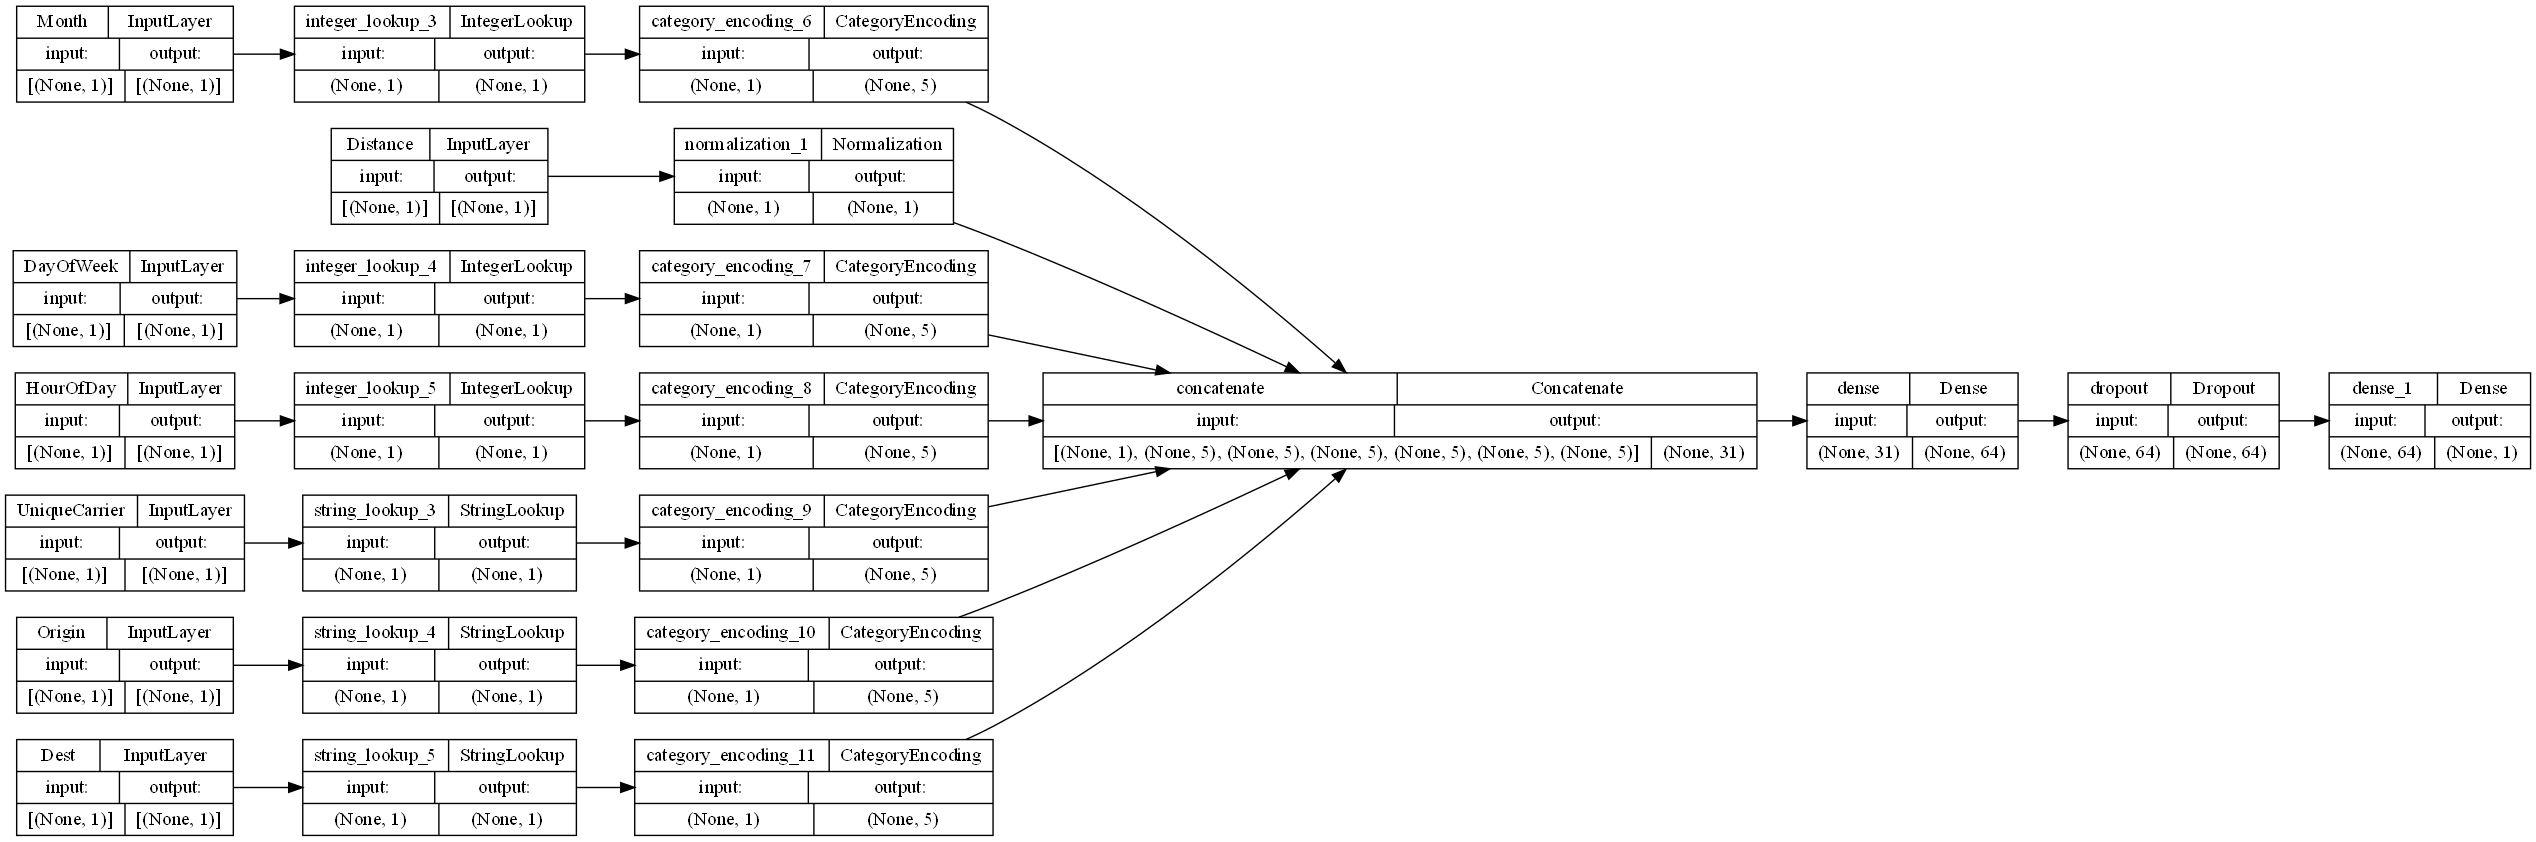

In [32]:
# Visualizing the connectivity graph

tf.keras.utils.plot_model(model, show_shapes=True, dpi=100, rankdir="LR")

### Training the Model

In [33]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
313/313 [==============================] - 2s 4ms/step - loss: 0.5088 - accuracy: 0.7947 - auc: 0.5469 - val_loss: 0.4810 - val_accuracy: 0.8069 - val_auc: 0.5956
Epoch 2/10
313/313 [==============================] - 1s 3ms/step - loss: 0.4900 - accuracy: 0.8048 - auc: 0.5770 - val_loss: 0.4810 - val_accuracy: 0.8068 - val_auc: 0.5964
Epoch 3/10
313/313 [==============================] - 1s 3ms/step - loss: 0.4871 - accuracy: 0.8050 - auc: 0.5850 - val_loss: 0.4809 - val_accuracy: 0.8068 - val_auc: 0.5977
Epoch 4/10
313/313 [==============================] - 1s 3ms/step - loss: 0.4863 - accuracy: 0.8052 - auc: 0.5869 - val_loss: 0.4811 - val_accuracy: 0.8069 - val_auc: 0.5951
Epoch 5/10
313/313 [==============================] - 1s 3ms/step - loss: 0.4858 - accuracy: 0.8051 - auc: 0.5883 - val_loss: 0.4806 - val_accuracy: 0.8070 - val_auc: 0.5988
Epoch 6/10
313/313 [==============================] - 1s 3ms/step - loss: 0.4849 - accuracy: 0.8052 - auc: 0.5920 - val_loss: 0.48

### Testing the Model

In [34]:
loss, accuracy, auc = model.evaluate(test_ds)
print("Loss: ", loss)
print("AUC: ", auc)
print("Accuracy: ", accuracy)

40/40 [==============================] - 0s 2ms/step - loss: 0.4871 - accuracy: 0.8023 - auc: 0.5988
Loss:  0.48708921670913696
AUC:  0.5987707376480103
Accuracy:  0.802299976348877


### Visualizing the validation loss and validation accuracy graphs

In [35]:
# Create function to plot graphs

import matplotlib.pyplot as plt

def plot_loss(loss, val_loss):
    plt.clf()
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_accuracy(acc, val_acc):
    plt.clf()
    epoch = range(1, len(acc) +1)
    plt.plot(epoch, acc, 'bo', label="Training Accuracy")
    plt.plot(epoch, val_acc, 'b', label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    

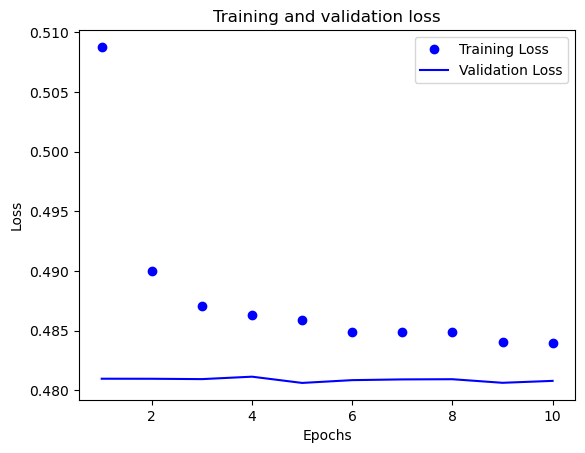

In [36]:
plot_loss(history.history['loss'], history.history['val_loss'])

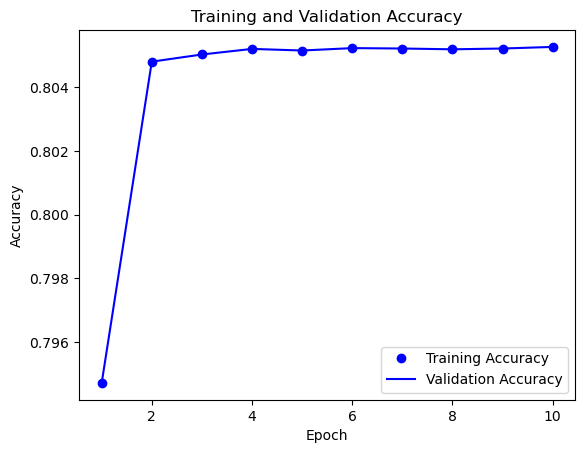

In [37]:
plot_accuracy(history.history['accuracy'], history.history['accuracy'])

### Saving and Reloading the Keras Model

In [41]:
model.save('flight_delay_classifier_third')
reloaded_model_2 = tf.keras.models.load_model('flight_delay_classifier_third')

INFO:tensorflow:Assets written to: flight_delay_classifier_third\assets


INFO:tensorflow:Assets written to: flight_delay_classifier_third\assets


### Getting a Prediction on a Sample

The model can be implemented to flight booking websites or apps and inputs the flight details so that passengers determine the probability of a flight being delayed.

In [43]:
# EXAMPLE 2

sample = {
    'Month': 5,
    'DayOfWeek': 5,
    'UniqueCarrier': 'MQ',
    'Origin': 'TVC',
    'Dest': 'ORD',
    'Distance': 224,
    'HourOfDay': 12,    
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model_2.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular flight had a %.1f percent probability "
    "of getting delayed." % (100 * prob)
)

1/1 [==============================] - 0s 200ms/step
This particular flight had a 55.4 percent probability of getting delayed.


# Whats Next?

In the next iteration, we will be working on creating a model using **Model Ensembling**, which is part of the advanced modelling technique found in Chapter 7 of 'Deep Learning with Python' by François Chollet.